## 知识蒸馏-CTT teacher->GRU student

In [1]:
import copy
import math
import torch
import pickle
import numpy as np
import pandas as pd
import geatpy as ea
from tqdm import tqdm
from torch import nn
from torch import optim
from fill.hot_filling import hot_fill
from fill.neighbour_filling import neighbour_fill
from filter.w_mean_filter import *
from filter.rssi_guass_filter import filter_guass
from filter.kalman_filter import filter_kalman
import torch.nn.functional as F
import matplotlib.pyplot as plt
import utils.calculate_param as cp
from dataset import data_read
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from multiprocessing.dummy import Pool as ThreadPool
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score, mean_squared_error

/Users/frank/Desktop/jupyter/RFID_TRANS/filter/


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

### 硬件设备准备

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### 加载数据集 近邻填充+高斯滤波

In [3]:
X_train_0, y_train_0 = data_read.load_data('train')
X_test_0, y_test_0 = data_read.load_data('test')

In [4]:
X_train_neighbour = [neighbour_fill(xi) for xi in X_train_0]
X_test_neighbour = [neighbour_fill(xi) for xi in X_test_0]
X_train_guass = [filter_guass(xi) for xi in X_train_neighbour]
X_test_guass = [filter_guass(xi) for xi in X_test_neighbour]
X_train_guass = np.array(X_train_guass)
X_test_guass = np.array(X_test_guass)

X_train_guass.shape

(2000, 50)

In [5]:
X_train = torch.from_numpy(X_train_guass).float().to(device) # [len * feature]
y_train = torch.from_numpy(y_train_0).float().to(device)
X_test = torch.from_numpy(X_test_guass).float().to(device) # [len * feature]
y_test = torch.from_numpy(y_test_0).float().to(device)

X_train.shape


torch.Size([2000, 50])

In [6]:
train_data_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=100, shuffle=False)
test_data_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=100, shuffle=False)

### 定义教师模型-CTT

In [7]:
# CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.out=nn.Linear(960, 50)

    def forward(self, x):
        x= self.conv1(x)
        # print(x.shape)
        x= self.conv2(x)
        # print(x.shape)
        x= x.view(-1, x.size(0) * x.size(1) * x.size(2))
        # print(x.shape)
        out = self.out(x)
        return out


# 位置编码类
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        out = x + self.pe[:x.size(0), :]
        return out


# 教师模型类
class TeacherTransformer(nn.Module):
    def __init__(self):
        super(TeacherTransformer, self).__init__()
        self.cnn = CNN()
        self.d_model = 128  # 词向量维度
        self.embedding_enc = nn.Linear(50, self.d_model)
        self.embedding_dec = nn.Linear(2, self.d_model)
        self.pos_encoding = PositionalEncoding(self.d_model)
        self.Transformer_layer = nn.Transformer(d_model=128, num_encoder_layers=3, num_decoder_layers=3, batch_first=True)
        self.FC_layer = nn.Linear(128, 2)

    def forward(self, src, tgt):
        # rssi进行cnn特征提取
        src = src.unsqueeze(0)
        src = self.cnn(src)
        # print(src.shape)
        # 使用线性层代替embedding
        src = self.embedding_enc(src).unsqueeze(0)
        tgt = self.embedding_dec(tgt).unsqueeze(0)
        src = self.pos_encoding(src)
        out = self.Transformer_layer(src, tgt)
        out = self.FC_layer(out)
        return out


### 教师模型设置

In [8]:
model = TeacherTransformer().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)

### 教师模型信息

In [9]:
# 输出教师模型的参数信息-380w参数
cp.get_summary(model, input_size=None)

torchinfo信息如下：
Layer (type:depth-idx)                                                 Param #
TeacherTransformer                                                     --
├─CNN: 1-1                                                             --
│    └─Sequential: 2-1                                                 --
│    │    └─Conv2d: 3-1                                                150
│    │    └─ReLU: 3-2                                                  --
│    │    └─MaxPool2d: 3-3                                             --
│    └─Sequential: 2-2                                                 --
│    │    └─Conv2d: 3-4                                                888
│    │    └─ReLU: 3-5                                                  --
│    │    └─MaxPool2d: 3-6                                             --
│    └─Linear: 2-3                                                     48,050
├─Linear: 1-2                                                          6,528
├─Linear:

### 教师模型训练

In [53]:
%%time

best_loss = 100000
best_epoch = 0
for epoch in range(150):
    epoch_loss = 0
    for X, y in train_data_loader:  # enc_inputs : [len * feature]->[2000 * 50]
        # print(X.shape)  # [100 * 50]
        # print(y.shape)  # [100 * 50]
        outputs = model(X, y)
        outputs = outputs.squeeze()  # [100 * 2]
        # print(outputs.shape)
        loss = criterion(outputs, y)
        loss_num = loss.item()
        epoch_loss += loss_num
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, './result/ctt_weight.pth')

    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(epoch_loss))

# 打印最佳的结果
print('best_loss::|',best_loss,'---best_epoch::|',best_epoch)


Epoch: 0001 loss = 129.998638
Epoch: 0002 loss = 47.602817
Epoch: 0003 loss = 42.132884
Epoch: 0004 loss = 37.284594
Epoch: 0005 loss = 28.369028
Epoch: 0006 loss = 19.852887
Epoch: 0007 loss = 12.045530
Epoch: 0008 loss = 10.521668
Epoch: 0009 loss = 9.377818
Epoch: 0010 loss = 6.554981
Epoch: 0011 loss = 4.498675
Epoch: 0012 loss = 4.578646
Epoch: 0013 loss = 4.446416
Epoch: 0014 loss = 3.611479
Epoch: 0015 loss = 2.867299
Epoch: 0016 loss = 3.022958
Epoch: 0017 loss = 2.838755
Epoch: 0018 loss = 2.951772
Epoch: 0019 loss = 2.784625
Epoch: 0020 loss = 2.155868
Epoch: 0021 loss = 2.203376
Epoch: 0022 loss = 2.301805
Epoch: 0023 loss = 1.971854
Epoch: 0024 loss = 1.692090
Epoch: 0025 loss = 1.646012
Epoch: 0026 loss = 1.750359
Epoch: 0027 loss = 1.609370
Epoch: 0028 loss = 1.515303
Epoch: 0029 loss = 1.694549
Epoch: 0030 loss = 1.409488
Epoch: 0031 loss = 1.695054
Epoch: 0032 loss = 1.545713
Epoch: 0033 loss = 1.238061
Epoch: 0034 loss = 1.355181
Epoch: 0035 loss = 1.561455
Epoch: 0036

### 教师模型评估

In [10]:
model = TeacherTransformer().to(device)
# 暂存教师模型为teacher_model
teacher_model = model
model.load_state_dict(torch.load('./result/ctt_weight.pth'))
model.eval()

pxy_all = []
y_all = []
for X, y in test_data_loader:
    pxy = model(X, y)
    pxy = pxy.cpu().detach().numpy().squeeze(0)
    y = y.cpu().detach().numpy()
    pxy_all.append(pxy)
    y_all.append(y)

# 计算指标
pxy_all = np.array(pxy_all).reshape(-1, 2)
y_all = np.array(y_all).reshape(-1, 2)
mae = mean_absolute_error(y_all, pxy_all)
mse = mean_squared_error(y_all, pxy_all)
rmse = mse ** 0.5
evs = explained_variance_score(y_all, pxy_all)
r2 = r2_score(y_all, pxy_all)

mmax = 0
mmin = 10000
for i in range(len(pxy_all)):
    mmax = max(mean_absolute_error(y_all[i], pxy_all[i]), mmax)
    mmin = min(mean_absolute_error(y_all[i], pxy_all[i]), mmin)

print({'mae': mae, 'mse': mse, 'rmse': rmse, 'evs': evs, 'r2': r2, 'mmax': mmax, 'mmin': mmin})

y_teacher = y_all[:20]
pxy = pxy_all[:20]
coor1 = pd.DataFrame(y_teacher)
coor1.columns = ['X', 'y']

coor2 = pd.DataFrame(pxy)
coor2.columns = ['PX', 'Py']

coor = pd.concat([coor1, coor2], axis=1)
coor.to_csv('./result/coordinate_all_ctt.csv')
print(coor)

{'mae': 0.13338129, 'mse': 0.028472332, 'rmse': 0.16873746556071798, 'evs': 0.9949590265750885, 'r2': 0.9860217061275907, 'mmax': 0.35820603, 'mmin': 0.017809458}
       X     y        PX        Py
0   0.21  3.47  0.124531  3.715504
1   1.13  1.96  1.084291  2.080899
2   3.38  2.58  3.346277  2.748064
3   4.07  2.72  4.168088  2.933629
4   1.58  2.47  1.576717  2.598555
5   3.43  1.61  3.406310  1.756241
6   1.22  0.74  1.135537  0.773024
7   2.33  1.97  2.292284  2.134232
8   0.33  3.56  0.246293  3.826063
9   3.53  4.28  3.744175  4.694170
10  4.42  3.69  4.702496  4.065153
11  3.67  0.34  3.764961  0.363934
12  2.57  0.37  2.540435  0.417595
13  3.14  3.22  3.148333  3.386683
14  4.76  3.34  4.985601  3.633575
15  1.70  3.71  1.709826  3.943636
16  3.50  1.20  3.539850  1.304910
17  0.68  4.65  0.656825  4.929386
18  1.09  4.59  1.065913  4.934533
19  0.25  3.70  0.169071  3.974638


### 教师模型定位效果可视化

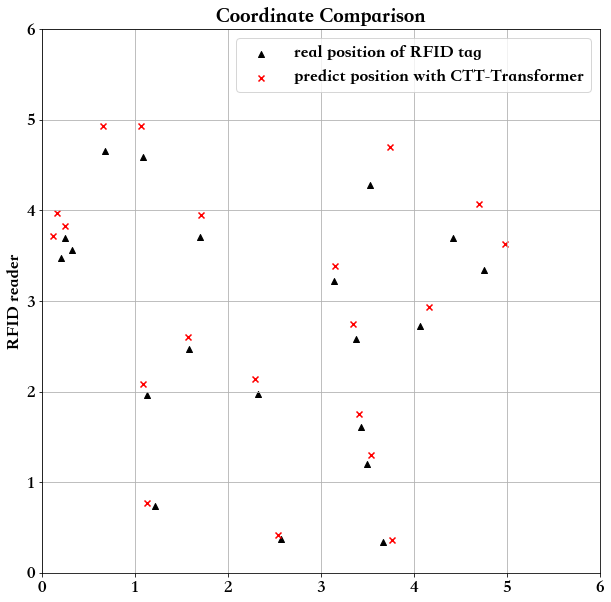

In [11]:
plt.figure(figsize=[10, 10])
plt.xlim((0, 6))
plt.ylim((0, 6))
plt.ylabel('RFID reader')
plt.title('Coordinate Comparison')
# 画图-标准坐标
plt.scatter(y_teacher[:, 0], y_teacher[:, 1], c='black', marker='^', label='real position of RFID tag')

# 画图-预测EA坐标
plt.scatter(pxy[:, 0], pxy[:, 1], c='red', marker='x', label = 'predict position with CTT-Transformer')

plt.legend()
plt.grid('True')
plt.savefig('./result/compare_coordinate_ctt.jpg', dpi=750, bbox_inches = 'tight')

### 定义学生模型-GRU模型

In [12]:
class StudentGRU(nn.Module):
    def __init__(self):
        super(StudentGRU, self).__init__()
        self.time_step = 50
        self.x_dim = 1
        self.h_dim = 60
        self.gru_layers = 1
        self.GRU_layer = nn.GRU(self.x_dim, self.h_dim, self.gru_layers, batch_first=True)
        self.FC = nn.Linear(self.h_dim, 2)


    def forward(self, x):
        batch, time_step, x_dim = x.size()
        h0 = torch.zeros((self.gru_layers, batch, self.h_dim)).to(device)
        output, hn = self.GRU_layer(x, h0)
        res = hn.squeeze(0)
        res = self.FC(res)
        return res

### 学生模型设置

In [13]:
# 从头先训练一下学生模型
model = StudentGRU().to(device)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### 学生模型信息

In [14]:
# 输出学生模型的参数信息-1w参数
cp.get_summary(model, input_size=None)

torchinfo信息如下：
Layer (type:depth-idx)                   Param #
StudentGRU                               --
├─GRU: 1-1                               11,340
├─Linear: 1-2                            122
Total params: 11,462
Trainable params: 11,462
Non-trainable params: 0


### 学生模型训练

In [15]:
%%time
best_loss = 100000
best_epoch = 0
for epoch in range(100):
    epoch_loss = 0
    for X, y in train_data_loader:
        outputs = model(X.unsqueeze(2))
        loss = criterion(outputs, y)
        loss_num = loss.item()
        epoch_loss += loss_num
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, './result/student_weight.pth')

    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(epoch_loss))

# 打印最佳的结果
print('best_loss::|',best_loss,'---best_epoch::|',best_epoch)


Epoch: 0001 loss = 122.107428
Epoch: 0002 loss = 47.278068
Epoch: 0003 loss = 37.876312
Epoch: 0004 loss = 32.536261
Epoch: 0005 loss = 26.213305
Epoch: 0006 loss = 22.373122
Epoch: 0007 loss = 21.071169
Epoch: 0008 loss = 20.120149
Epoch: 0009 loss = 19.141215
Epoch: 0010 loss = 17.978291
Epoch: 0011 loss = 16.451362
Epoch: 0012 loss = 14.423084
Epoch: 0013 loss = 12.214550
Epoch: 0014 loss = 10.656858
Epoch: 0015 loss = 9.471471
Epoch: 0016 loss = 8.668101
Epoch: 0017 loss = 7.969093
Epoch: 0018 loss = 7.692502
Epoch: 0019 loss = 7.541159
Epoch: 0020 loss = 7.283013
Epoch: 0021 loss = 6.562838
Epoch: 0022 loss = 6.500648
Epoch: 0023 loss = 6.023684
Epoch: 0024 loss = 5.855993
Epoch: 0025 loss = 5.425782
Epoch: 0026 loss = 4.998297
Epoch: 0027 loss = 5.450473
Epoch: 0028 loss = 4.806328
Epoch: 0029 loss = 4.540754
Epoch: 0030 loss = 4.441662
Epoch: 0031 loss = 4.421530
Epoch: 0032 loss = 4.619637
Epoch: 0033 loss = 4.207857
Epoch: 0034 loss = 3.999857
Epoch: 0035 loss = 3.925165
Epoch

### 学生模型评估

In [17]:
model = StudentGRU()
# 暂存不加蒸馏学生模型为student_model
student_model = model

model.load_state_dict(torch.load('./result/student_weight.pth'))
model.eval()

pxy = model(X_test.unsqueeze(2))
pxy = pxy.cpu().detach().numpy()
# 计算指标
mae = mean_absolute_error(y_test, pxy)
mse = mean_squared_error(y_test, pxy)
rmse = mse ** 0.5
evs = explained_variance_score(y_test, pxy)
r2 = r2_score(y_test, pxy)

mmax = 0
mmin = 10000
for i in range(len(pxy)):
    mmax = max(mean_absolute_error(y_test[i], pxy[i]), mmax)
    mmin = min(mean_absolute_error(y_test[i], pxy[i]), mmin)

print({'mae': mae, 'mse': mse, 'rmse': rmse, 'evs': evs, 'r2': r2, 'mmax': mmax, 'mmin': mmin})


{'mae': 0.30248207, 'mse': 0.17594299, 'rmse': 0.41945558430374724, 'evs': 0.9139597117900848, 'r2': 0.9137655269198061, 'mmax': 1.4075177, 'mmin': 0.020872474}


### 学生模型定位效果可视化

In [18]:
y_test = np.array(y_test)
y_student = y_test[:20]
pxy = pxy[:20]
coor1 = pd.DataFrame(y_student)
coor1.columns = ['X', 'y']

coor2 = pd.DataFrame(pxy)
coor2.columns = ['PX', 'Py']

coor = pd.concat([coor1, coor2], axis=1)
coor.to_csv('./result/coordinate_all_student.csv')
coor

,X,y,PX,Py
0,0.21,3.47,0.529556,3.653620
1,1.13,1.96,1.155327,0.791723
2,3.38,2.58,3.175576,1.932925
3,4.07,2.72,4.124848,3.070251
4,1.58,2.47,1.583962,1.589060
5,3.43,1.61,2.916111,1.182419
6,1.22,0.74,1.341990,0.820726
7,2.33,1.97,2.216176,1.262219
8,0.33,3.56,0.479064,3.963069
9,3.53,4.28,3.488793,4.035165


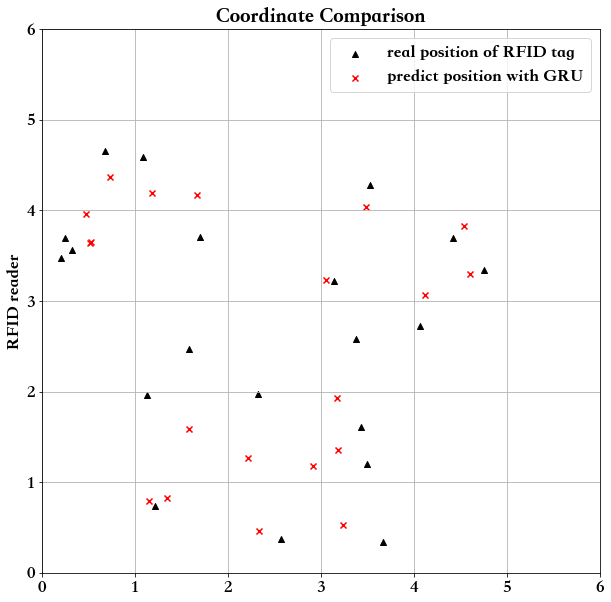

In [19]:
plt.figure(figsize=[10, 10])
plt.xlim((0, 6))
plt.ylim((0, 6))
plt.ylabel('RFID reader')
plt.title('Coordinate Comparison')
# 画图-标准坐标
plt.scatter(y_student[:, 0], y_student[:, 1], c='black', marker='^', label='real position of RFID tag')

# 画图-预测EA坐标
plt.scatter(pxy[:, 0], pxy[:, 1], c='red', marker='x', label = 'predict position with GRU')

plt.legend()
plt.grid('True')
plt.savefig('./result/compare_coordinate_student.jpg', dpi=750, bbox_inches = 'tight')

### 知识蒸馏准备与设置

In [25]:
# 准备预训练好的教师模型
teacher_model.eval()

# 准备新的学生模型
model = StudentGRU().to(device)

# 蒸馏温度
T = 7

# 参数设置
# hard_loss
hard_loss = nn.MSELoss()
# soft_loss kl散度
soft_loss = nn.KLDivLoss(reduction='batchmean')

alpha = 0.5
beta = 1
m = 0.8

# 回归分析的损失函数设置 = 平滑l1loss + beta * 范围loss
# loss = smoothl1loss + alpha * boundloss
loss1 = nn.SmoothL1Loss()
loss2 = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

### 知识蒸馏训练

In [26]:
%%time
best_loss = 100000
best_epoch = 0
for epoch in range(100):
    epoch_loss = 0
    for X, y in train_data_loader:
        X, y = X.to(device), y.to(device)
        # 教师模型预测
        with torch.no_grad():
            teacher_outputs = teacher_model(X, y)
            # print(teacher_outputs)
        # 学生模型预测
        student_outputs = model(X.unsqueeze(2))
        # print(student_outputs)
        # student_loss = hard_loss(student_outputs, y)
        # # 计算蒸馏后的预测结果及soft_loss
        # distillation_loss = soft_loss(
        #     F.softmax(student_outputs/T, dim=1),
        #     F.softmax(teacher_outputs/T, dim=1)
        # )
        # # 将 hard_loss 和 soft_loss 加权求和
        # loss = alpha * student_loss + (1-alpha) * distillation_loss
        # 回归损失
        ls = loss2(student_outputs, y)
        lt = loss2(teacher_outputs, y)
        loss = loss1(student_outputs, y)  # smooth loss
        if ls.item() - lt.item() > m:  # bound loss
            loss += beta * ls.item()
        # 反向传播,优化权重
        optimizer.zero_grad()
        epoch_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, './result/distillation_weight.pth')

    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(epoch_loss))

# 打印最佳的结果
print('best_loss::|',best_loss,'---best_epoch::|',best_epoch)


/Users/frank/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([100, 2])) that is different to the input size (torch.Size([1, 100, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0001 loss = 75.443349
Epoch: 0002 loss = 35.368917
Epoch: 0003 loss = 31.604799
Epoch: 0004 loss = 28.821428
Epoch: 0005 loss = 21.056590
Epoch: 0006 loss = 8.849128
Epoch: 0007 loss = 11.018884
Epoch: 0008 loss = 7.571817
Epoch: 0009 loss = 4.529858
Epoch: 0010 loss = 5.104319
Epoch: 0011 loss = 7.241560
Epoch: 0012 loss = 9.588407
Epoch: 0013 loss = 4.976638
Epoch: 0014 loss = 12.513511
Epoch: 0015 loss = 8.326972
Epoch: 0016 loss = 4.388624
Epoch: 0017 loss = 5.973000
Epoch: 0018 loss = 5.087734
Epoch: 0019 loss = 3.920780
Epoch: 0020 loss = 5.168916
Epoch: 0021 loss = 4.361026
Epoch: 0022 loss = 4.022118
Epoch: 0023 loss = 3.802086
Epoch: 0024 loss = 3.747198
Epoch: 0025 loss = 4.249961
Epoch: 0026 loss = 3.650098
Epoch: 0027 loss = 4.818716
Epoch: 0028 loss = 3.397717
Epoch: 0029 loss = 3.451383
Epoch: 0030 loss = 3.217734
Epoch: 0031 loss = 3.549889
Epoch: 0032 loss = 3.307137
Epoch: 0033 loss = 3.246635
Epoch: 0034 loss = 3.587788
Epoch: 0035 loss = 3.514326
Epoch: 0036 l

### 蒸馏模型评估

In [27]:
model = StudentGRU()
model.load_state_dict(torch.load('./result/distillation_weight.pth'))
model.eval()

pxy = model(X_test.unsqueeze(2))
pxy = pxy.cpu().detach().numpy()

# 计算指标
mae = mean_absolute_error(y_test, pxy)
mse = mean_squared_error(y_test, pxy)
rmse = mse ** 0.5
evs = explained_variance_score(y_test, pxy)
r2 = r2_score(y_test, pxy)

mmax = 0
mmin = 10000
for i in range(len(pxy)):
    mmax = max(mean_absolute_error(y_test[i], pxy[i]), mmax)
    mmin = min(mean_absolute_error(y_test[i], pxy[i]), mmin)

print({'mae': mae, 'mse': mse, 'rmse': rmse, 'evs': evs, 'r2': r2, 'mmax': mmax, 'mmin': mmin})


{'mae': 0.4365049, 'mse': 0.3368034, 'rmse': 0.5803476600081838, 'evs': 0.8657798767089844, 'r2': 0.834821027995134, 'mmax': 1.6381856, 'mmin': 0.014838576}


### 蒸馏模型定位效果可视化

In [23]:
y_distill = y_test[:20]
pxy = pxy[:20]
coor1 = pd.DataFrame(y_distill)
coor1.columns = ['X', 'y']

coor2 = pd.DataFrame(pxy)
coor2.columns = ['PX', 'Py']

coor = pd.concat([coor1, coor2], axis=1)
coor.to_csv('./result/coordinate_all_distill.csv')
coor

,X,y,PX,Py
0,0.21,3.47,0.774119,4.020876
1,1.13,1.96,1.297446,1.467357
2,3.38,2.58,3.103426,2.311676
3,4.07,2.72,3.918773,3.422728
4,1.58,2.47,1.670892,1.882996
5,3.43,1.61,2.977580,1.745612
6,1.22,0.74,1.221253,1.090062
7,2.33,1.97,2.219710,1.498234
8,0.33,3.56,0.652521,4.032351
9,3.53,4.28,3.649781,4.448157


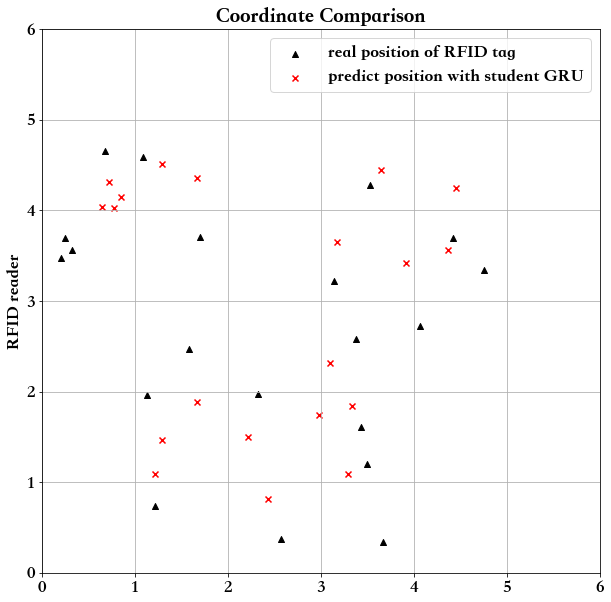

In [24]:
plt.figure(figsize=[10, 10])
plt.xlim((0, 6))
plt.ylim((0, 6))
plt.ylabel('RFID reader')
plt.title('Coordinate Comparison')
# 画图-标准坐标
plt.scatter(y_distill[:, 0], y_distill[:, 1], c='black', marker='^', label='real position of RFID tag')

# 画图-预测EA坐标
plt.scatter(pxy[:, 0], pxy[:, 1], c='red', marker='x', label = 'predict position with student GRU')

plt.legend()
plt.grid('True')
plt.savefig('./result/compare_coordinate_distill.jpg', dpi=750, bbox_inches = 'tight')

### 定义问题类

In [19]:
class MOEA(ea.Problem):
    def __init__(self, train_data_loader, test_data_loader):
        name = 'MOEA'
        M = 1 # 初始化M（目标维数）
        maxormins = [-1] # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 2 # 初始化Dim（决策变量维数）
        varTypes = np.array([0] * Dim) # 初始化varTypes 0-连续
        lb = [5, 0.1] # 决策变量下界
        ub = [10, 0.9] # 决策变量上界
        lbin = [1] * Dim # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
        # 数据设置
        self.train_data_loader = train_data_loader
        self.test_data_loader = test_data_loader


    # 目标函数，采用多线程加速计算
    def aimFunc(self, pop):
        Vars = pop.Phen # 得到决策变量矩阵
        # print(Vars)
        pop.ObjV = np.zeros((pop.sizes, 1)) # 初始化种群个体目标函数值列向量
        def subAimFunc(i):
            epochs, alpha = int(Vars[i, 0]), float(Vars[i, 1])
            print(epochs, alpha)
            final_loss = 0
            for epoch in range(epochs):
                for data,targets in tqdm(train_data_loader):
                    data, targets = data.to(device), targets.to(device)
                    # 教师模型预测
                    with torch.no_grad():
                        teacher_outputs = teacher_model(data)
                    # 学生模型预测
                    student_outputs = model(data)
                    student_loss = hard_loss(student_outputs, targets)
                    # 计算蒸馏后的预测结果及soft_loss
                    distillation_loss = soft_loss(
                        F.softmax(student_outputs/T, dim=1),
                        F.softmax(teacher_outputs/T, dim=1)
                    )
                    # 将 hard_loss 和 soft_loss 加权求和
                    loss = alpha * student_loss + (1-alpha) * distillation_loss
                    final_loss = loss.item()
                    # 反向传播,优化权重
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            pop.ObjV[i] = final_loss # 最小化最终的损失作为目标函数
        pool = ThreadPool(processes=2) # 设置池的大小
        pool.map(subAimFunc, list(range(pop.sizes))) # 散列种群每个个体进行加速计算


    # 代入优化后的参数先训练再对测试集进行检验，计算指标
    def test(self, epochs, alpha):
        for epoch in range(epochs):
            for data,targets in tqdm(train_data_loader):
                data, targets = data.to(device), targets.to(device)
                # 教师模型预测
                with torch.no_grad():
                    teacher_outputs = teacher_model(data)
                # 学生模型预测
                student_outputs = model(data)
                student_loss = hard_loss(student_outputs, targets)
                # 计算蒸馏后的预测结果及soft_loss
                distillation_loss = soft_loss(
                    F.softmax(student_outputs/T, dim=1),
                    F.softmax(teacher_outputs/T, dim=1)
                )
                # 将 hard_loss 和 soft_loss 加权求和
                loss = alpha * student_loss + (1-alpha) * distillation_loss
                # 反向传播,优化权重
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # 测试集上评估性能
            model.eval()
            num_correct = 0
            num_samples = 0

            with torch.no_grad():
                for x,y in test_data_loader:
                    x, y = x.to(device), y.to(device)
                    outputs = model(x)
                    pred = outputs.max(1).indices
                    num_correct += (pred == y).sum()
                    num_samples += pred.size(0)
                acc = (num_correct/num_samples).item()

            model.train()
            print("Epoch:{}\t Accuracy:{:4f}".format(epoch + 1, acc))

        torch.save(model.state_dict(), "./models/moea_distillation.pth")



### 参数调优

In [20]:
"""===============================实例化问题对象==========================="""

problem = MOEA(train_data_loader, test_data_loader) # 生成问题对象

"""=================================种群设置==============================="""

Encoding = 'RI'       # 编码方式
NIND = 10             # 种群规模
Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders) # 创建区域描述器
population = ea.Population(Encoding, Field, NIND) # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）

"""===============================算法参数设置============================="""

myAlgorithm = ea.soea_DE_rand_1_bin_templet(problem, population) # 实例化一个算法模板对象
myAlgorithm.MAXGEN = 10 # 最大进化代数
myAlgorithm.trappedValue = 1e-6 # “进化停滞”判断阈值
myAlgorithm.maxTrappedCount = 10 # 进化停滞计数器最大上限值，如果连续maxTrappedCount代被判定进化陷入停滞，则终止进化
myAlgorithm.logTras = 1  # 设置每隔多少代记录日志，若设置成0则表示不记录日志
myAlgorithm.verbose = True  # 设置是否打印输出日志信息
myAlgorithm.drawing = 1  # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制目标空间过程动画；3：绘制决策空间过程动画）

"""===========================调用算法模板进行种群进化======================="""

[BestIndi, population] = myAlgorithm.run()  # 执行算法模板，得到最优个体以及最后一代种群
BestIndi.save()  # 把最优个体的信息保存到文件中

"""==================================输出结果============================="""

print('用时：%f 秒' % myAlgorithm.passTime)
print('评价次数：%d 次' % myAlgorithm.evalsNum)
if BestIndi.sizes != 0:
    print('最优的目标函数值为：%s' % BestIndi.ObjV[0][0])
    print('最优的控制变量值为：')
    for i in range(BestIndi.Phen.shape[1]):
        print(BestIndi.Phen[0, i])
else:
    print('没找到可行解。')

"""=================================检验结果==============================="""

problem.test(epochs= int(BestIndi.Phen[0][0]), alpha= float(BestIndi.Phen[0][1]))


7 0.3189171239733696


6 0.2855765145272017


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 2/938 [00:00<00:54, 17.05it/s]


6 0.8424268286675215



  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 2/938 [00:00<00:52, 17.78it/s]

  0%|          | 4/938 [00:00<00:51, 18.15it/s]

 94%|█████████▎| 878/938 [00:08<00:00, 102.62it/s]


  1%|          | 9/938 [00:00<00:48, 19.11it/s]]


6 0.8656420316547155


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:05, 14.39it/s]]


9 0.6277091335505247


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 4/938 [00:00<00:25, 37.06it/s]]

  1%|          | 10/938 [00:00<00:26, 34.80it/s]


  3%|▎         | 31/938 [00:00<00:23, 38.58it/s]

  4%|▍         | 38/938 [00:01<00:19, 45.81it/s]

  5%|▍         | 46/938 [00:01<00:16, 54.51it/s]

  6%|▌         | 54/938 [00:01<00:14, 61.32it/s]

  7%|▋         | 65/938 [00:01<00:11, 74.37it/s]

  8%|▊         | 76/938 [00:01<00:10, 83.75it/s]

  9%|▉         | 86/938 [00:01<00:09, 88.29it/s]

 10%|█         | 96/938 [00:01<00:09, 89.71it/s]

 11%|█▏        | 106/938 [00:01<00:09, 85.26it/s]

 12%|█▏        | 116/938 [00:01<00:09, 87.53it/s]

 13%|█▎        | 125/938 [00:02<00:09, 87.56it/s]

 14%|█▍        | 134/938 [00:02<00:09, 86.86it/s]

 15%|█▌        | 143/938 [00:02<00:09, 87.52it/s]

 16%|█▌        | 152/938 [00:02<00:09, 86.56it/s]

 17%|█▋        | 163/938 [00:02<00:08, 92.49it/s]

 19%|█▊        | 174/938 [00:02<00:08, 95.28it/s]

 20%|█▉        | 184/938 [00:02<00:08, 92.35it/s]


8 0.2740337282419205


100%|██████████| 938/938 [00:08<00:00, 116.82it/s]


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [20, 10]], which is output 0 of AsStridedBackward0, is at version 23416; expected version 23415 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).